# HistomicsTK

I'll also perform image normalisation with **HistomicsTK**.\
Actually, the methods are always the same, the only difference is performing them with or without masking.
- Macenko
- Mecenko with masking
- Reinhard
- Reinhard with masking

---

For the installation, in the relative environment, run:
```sh
python -m pip install histomicstk --find-links https://girder.github.io/large_image_wheels
```

API can be found [here](https://digitalslidearchive.github.io/HistomicsTK/installation.html#installing-histomicstk-as-a-python-toolkit).

In particular, I'm applying the code as in the example [here](https://digitalslidearchive.github.io/HistomicsTK/examples/color_normalization_and_augmentation.html).

---
# 0. - Imports, paths and GPU devices

In [2]:
import histomicstk
import os
import matplotlib.pyplot as plt
import subprocess
from PIL import Image
import numpy as np
#import girder_client
from skimage.transform import resize
from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap
from histomicstk.preprocessing.color_normalization import reinhard
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_image_from_htk_response)
from histomicstk.preprocessing.color_normalization.\
    deconvolution_based_normalization import deconvolution_based_normalization
from histomicstk.preprocessing.color_deconvolution.\
    color_deconvolution import color_deconvolution_routine, stain_unmixing_routine
from histomicstk.preprocessing.augmentation.\
    color_augmentation import rgb_perturb_stain_concentration, perturb_stain_concentration
from histomicstk.preprocessing.color_deconvolution import rgb_separate_stains_macenko_pca#, rgb_to_od
from skimage.transform import resize
from skimage.morphology import remove_small_objects
#from histomicstk.preprocessing.color_deconvolution import 

Setting the working directory as the actual one.

In [3]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/2_image_normalisation/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/2_image_normalisation


Setting the paths and some variables.

In [4]:
# Set paths
INPUT_FOLDER = "../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/"  # Replace with the path to your folder containing images
tiles_info = INPUT_FOLDER.split('/')

---
# 1. - Normalisation methods

## 1.1 - Reinhard without masking

You must set the next variable `use_default_target` to `True` or `False` depending if you want to use the predefined values or a reference image as target for the normalisation.

In [6]:
use_default_target = False   # True if you want to use the default values from function example, False for using the choosen target image 
normalisation_method = 'histomicsTK_reinhard_nomasking'

In [7]:
if use_default_target:
    # Setting up the paths for default target
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/target_is_default"
    print(output_folder)
    
    # Using the target values from the function example
    # color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
    cnorm = {'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
             'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),}
    
else:
    # Setting up the paths using a personalised image as target
    TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
    target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
    print(output_folder)
    
    # Compute target statistics from target image
    target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
    target_array = np.array(target)
    cnorm = {'mu': target_array.mean(axis=(0, 1)),
             'sigma': target_array.std(axis=(0, 1)),}
    

# Let's create the output folder files
os.makedirs(output_folder, exist_ok=True)


# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise.txt"

with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles have failed normalization:\n")
    
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            # Load image
            img = Image.open(image_path).convert("RGB")
            tissue_rgb = np.array(img)

            # Perform normalization
            tissue_rgb_normalized = reinhard(tissue_rgb, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'])
            
            # Convert to PIL and save
            img_normed_pil = Image.fromarray(tissue_rgb_normalized.astype('uint8')).convert("RGB")
            output_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_{normalisation_method}.jpg")
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}: {str(e)}\n")

# eventually deleting the previous time log file
for filename in os.listdir(output_folder):
    if filename.startswith("0_started_"):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):  # Check if it is a file
            os.remove(file_path)      # Delete the file
            print(f"Deleted: {file_path}")

# saving the start and finish time in the file's name for simplicity in the reading.
with open(f"{output_folder}/0_started_at_{starttime}_finished_at_{datetime.datetime.now()}.txt", "w") as file:
    file.write(f"The run started at {starttime} and finished at {datetime.datetime.now()}.")

./output/satac_C1/v3_allspots/tiles_100/histomicsTK_reinhard_nomasking/target_is_reference_full


/disk2/user/gabgam/miniconda3/envs/he_histomicstk_39/lib/python3.9/site-packages/histomicstk/preprocessing/color_conversion/lab_to_rgb.py:44: RuntimeWarning: overflow encountered in exp
  im_lms = np.exp(im_lms)
/disk2/user/gabgam/miniconda3/envs/he_histomicstk_39/lib/python3.9/site-packages/histomicstk/preprocessing/color_normalization/reinhard.py:110: RuntimeWarning: invalid value encountered in cast
  im_normalized = im_normalized.astype(np.uint8)


## 1.2 - Reinhard with masking

Actually, masking should be done if we have a lot of white space, like on the WSI, but here I'll perform it anyway.

In [ ]:
if use_default_target:
    # Setting up the paths for default target
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/target_is_default"
    print(output_folder)
    
    # Using the target values from the function example
    # color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
    cnorm = {'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
             'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),}
    
else:
    # Setting up the paths using a personalised image as target
    TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
    target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
    print(output_folder)
    
    # Compute target statistics from target image
    target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
    target_array = np.array(target)
    cnorm = {'mu': target_array.mean(axis=(0, 1)),
             'sigma': target_array.std(axis=(0, 1)),}
    

# Let's create the output folder files
os.makedirs(output_folder, exist_ok=True)


# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise.txt"

with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles have failed normalization:\n")
    
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            # Load image
            img = Image.open(image_path).convert("RGB")
            tissue_rgb = np.array(img)
            
            # Mask extraction
            mask_out, _ = get_tissue_mask(tissue_rgb, #deconvolve_first=True,
                n_thresholding_steps=1, sigma=1.5, min_size=30)
            mask_out = resize(mask_out == 0, output_shape=tissue_rgb.shape[:2],
                    order=0, preserve_range=True) == 1
            
            # Perform normalization
            tissue_rgb_normalized = reinhard(tissue_rgb, 
                                             target_mu=cnorm['mu'], 
                                             target_sigma=cnorm['sigma'], 
                                             mask_out=mask_out)
            
            # Convert to PIL and save
            img_normed_pil = Image.fromarray(tissue_rgb_normalized.astype('uint8')).convert("RGB")
            output_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_{normalisation_method}.jpg")
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}: {str(e)}\n")

# eventually deleting the previous time log file
for filename in os.listdir(output_folder):
    if filename.startswith("0_started_"):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):  # Check if it is a file
            os.remove(file_path)      # Delete the file
            print(f"Deleted: {file_path}")

# saving the start and finish time in the file's name for simplicity in the reading.
with open(f"{output_folder}/0_started_at_{starttime}_finished_at_{datetime.datetime.now()}.txt", "w") as file:
    file.write(f"The run started at {starttime} and finished at {datetime.datetime.now()}.")

## 1.3 - Macenko without masking.

In [7]:
normalisation_method = 'histomicsTK_macenko_nomasking'

As it can be seen in some of the commented sections, I've also tried to estimate the H&E stains values with the `rgb_separate_stains_macenko_pca()` function, as suggested by the script in the [tutorial](https://digitalslidearchive.github.io/HistomicsTK/examples/color_deconvolution.html), however, it doesn't work properly, so I'll never show the results. Still, here I'm describing the parameter that I've tried to use:

Regarding `I_0` parameter.\
Here, they say: *The RGB-to-SDA conversion is parameterized by the background intensity of the image, here called I_0, which we set to 255 (full white; as a scalar it is applied across all channels) as there is no background in the image.*\
However, I set it to 240, as it's the default value for brightfield images.

In [8]:
# # Setting up the paths for the default target array proposed in the tutorial
# output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/target_is_default"
# print(output_folder)

# # TCGA-A2-A3XS-DX1_xmin21421_ymin37486_.png, Amgad et al, 2019)
# # for macenco (obtained using rgb_separate_stains_macenko_pca()
# # and reordered such that columns are the order:
# # Hamtoxylin, Eosin, Null
# W_target = np.array([
#     [0.5807549,  0.08314027,  0.08213795],
#     [0.71681094,  0.90081588,  0.41999816],
#     [0.38588316,  0.42616716, -0.90380025],
# ])
# im_target = None
    
# Setting up the paths using a personalised image as target
TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
print(output_folder)

# Compute target statistics from target image
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
im_target = np.array(target)
#I_0 = 240 # 240 is the default for brightfield images. Otherwise 255.
#W_target= rgb_separate_stains_macenko_pca(target_array, I_0)
#print(W_target)
#W_target = None

# Let's create the output folder files
os.makedirs(output_folder, exist_ok=True)

# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise.txt"


# Parameters for stain unmixing routine
stain_unmixing_routine_params = {
    'stains': ['hematoxylin', 'eosin'],
    'stain_unmixing_method': 'macenko_pca',
}

# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise_macenko.txt"

with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles have failed normalization:\n")
    
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            # Load image
            img = Image.open(image_path).convert("RGB")
            tissue_rgb = np.array(img)

            # Mask extraction without resizing because it's not a WSI, it's quite a small image
            mask_out, _ = get_tissue_mask(tissue_rgb, #deconvolve_first=True,
                n_thresholding_steps=1, sigma=1.5, min_size=30)
            # mask_out = resize(mask_out == 0, output_shape=tissue_rgb.shape[:2],
            #     order=0, preserve_range=True) == 1
            
            # Perform Macenko normalization
            tissue_rgb_normalized = deconvolution_based_normalization(
                tissue_rgb,
                #W_target=W_target,
                im_target = im_target,
                stain_unmixing_routine_params=stain_unmixing_routine_params,
                mask_out = mask_out
            )
            
            # Clipping values that go out of range [0, 1]
            #tissue_rgb_normalized = np.clip(tissue_rgb_normalized, 0, 1)
            
            # Convert to PIL and save
            img_normed_pil = Image.fromarray((tissue_rgb_normalized * 255).astype('uint8'))
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_macenko_htk_normalized_no_masking.jpg")
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}: {str(e)}\n")


./output/satac_C1/v3_allspots/tiles_100/histomicsTK_macenko_nomasking/target_is_reference_sparser


/disk2/user/gabgam/miniconda3/envs/he_histomicstk_39/lib/python3.9/site-packages/histomicstk/preprocessing/color_deconvolution/complement_stain_matrix.py:30: RuntimeWarning: invalid value encountered in divide
  return np.array([stain0, stain1, stain2 / np.linalg.norm(stain2)]).T


stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}
Estimated stain colors (rows):
[[0.24409889 0.87565789 0.41670011]
 [0.5463101  0.75480993 0.36305267]]


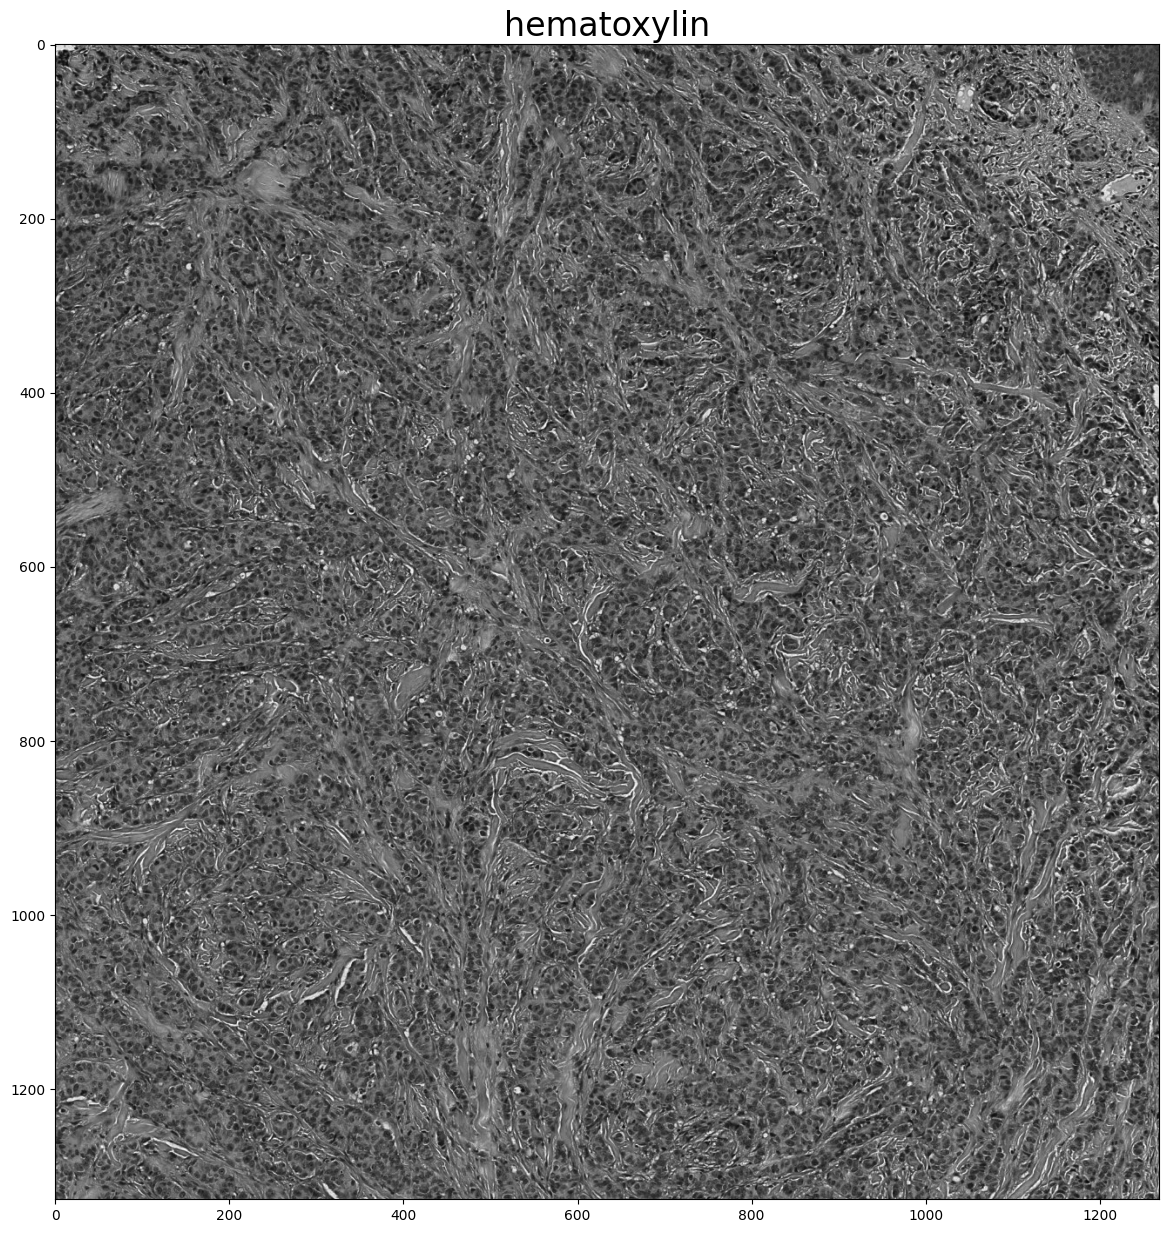

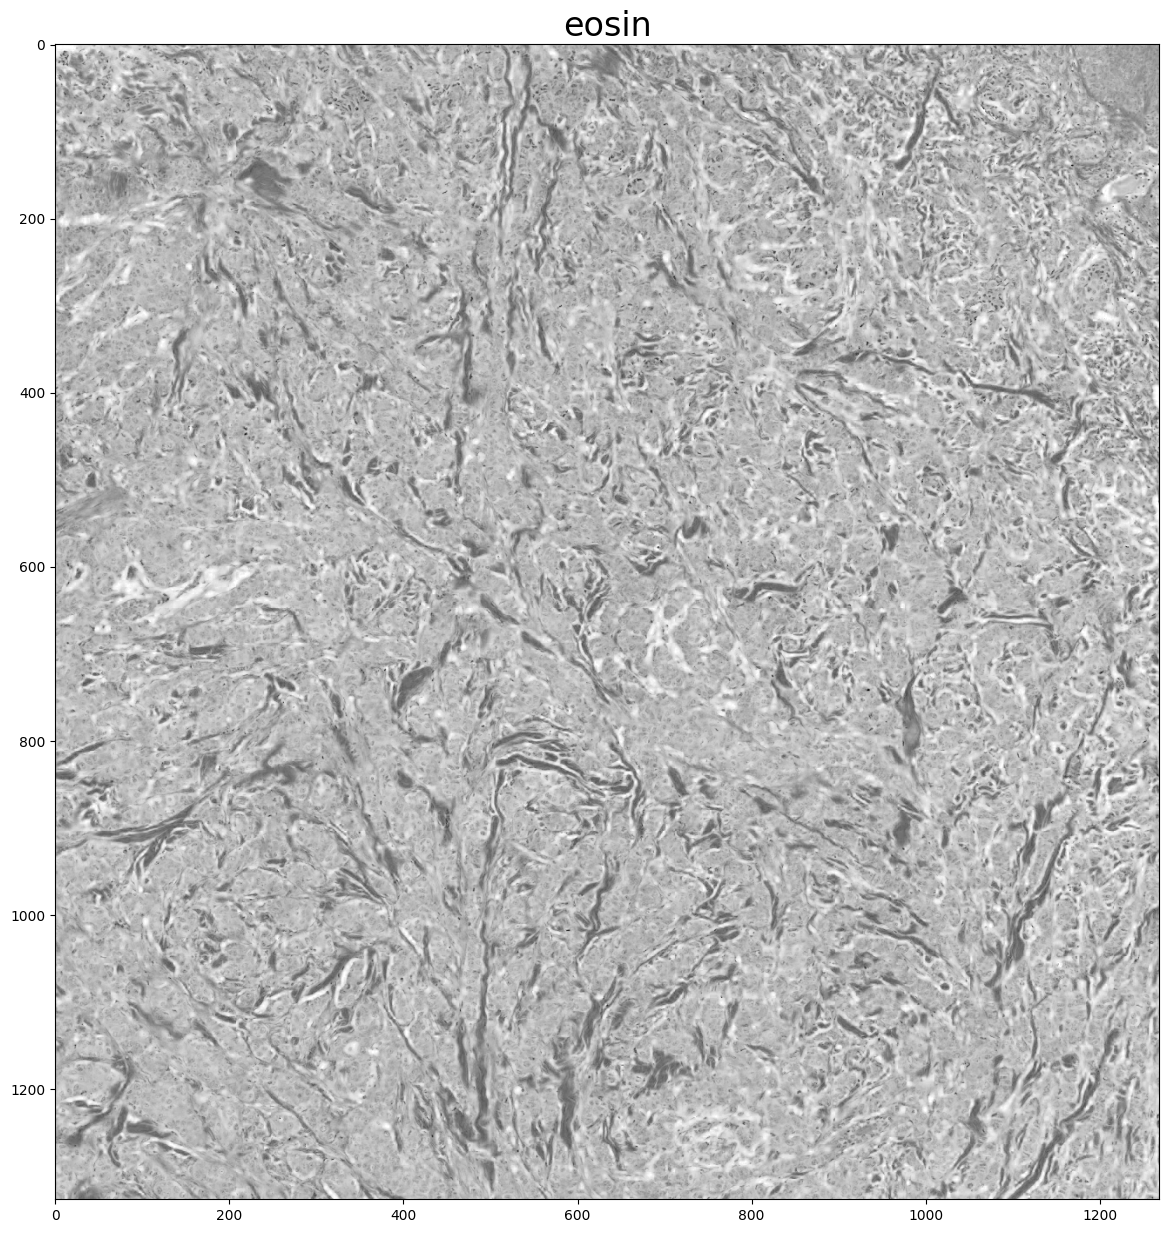

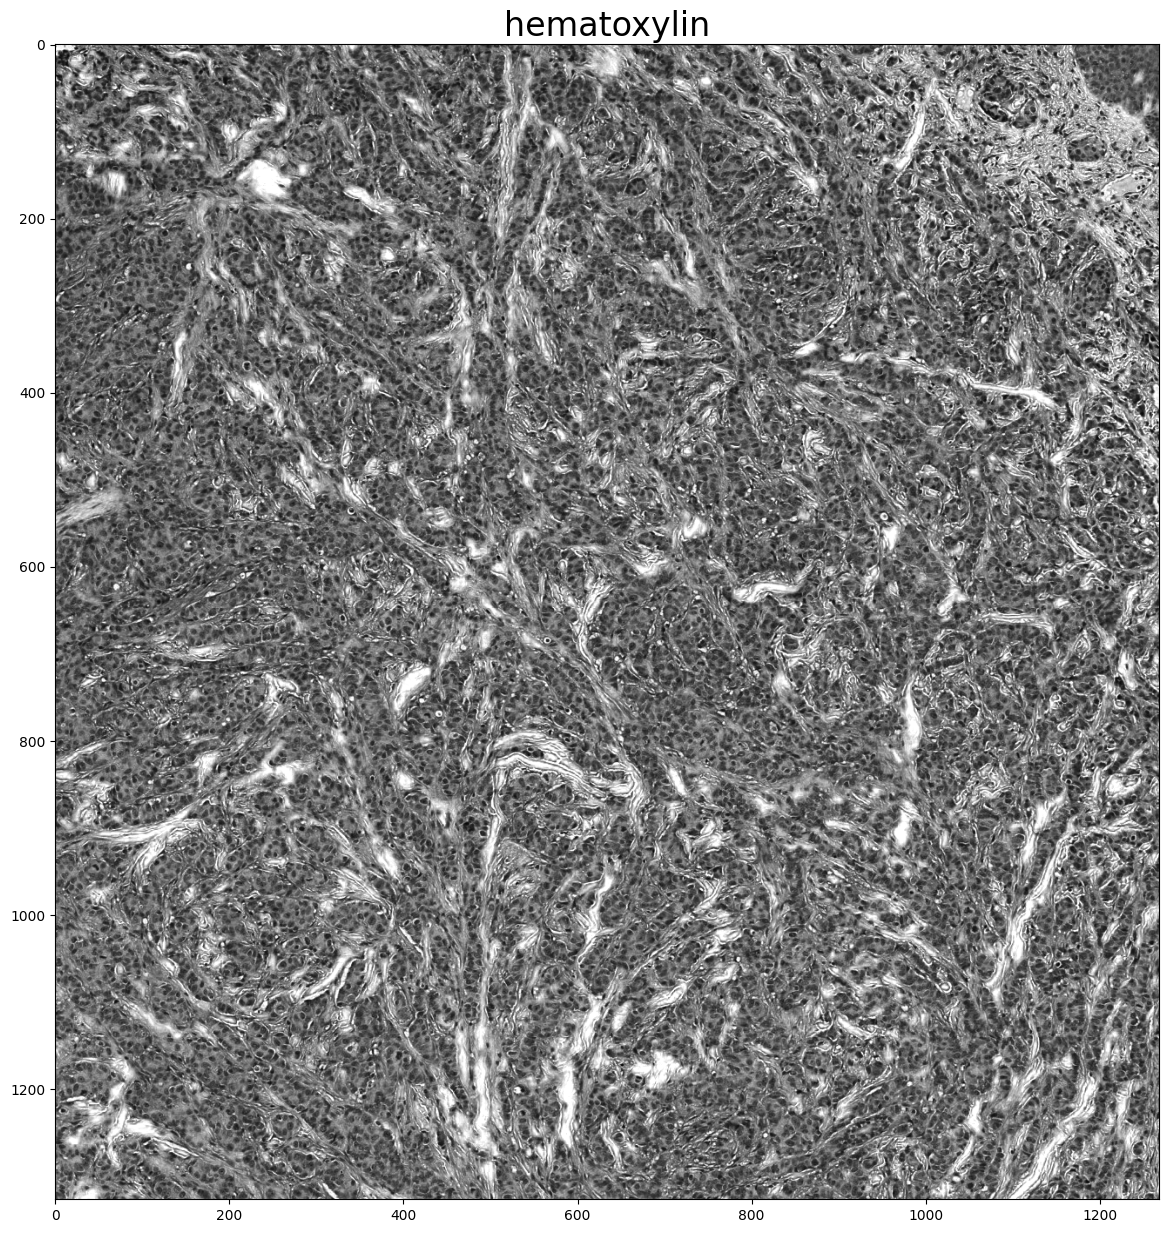

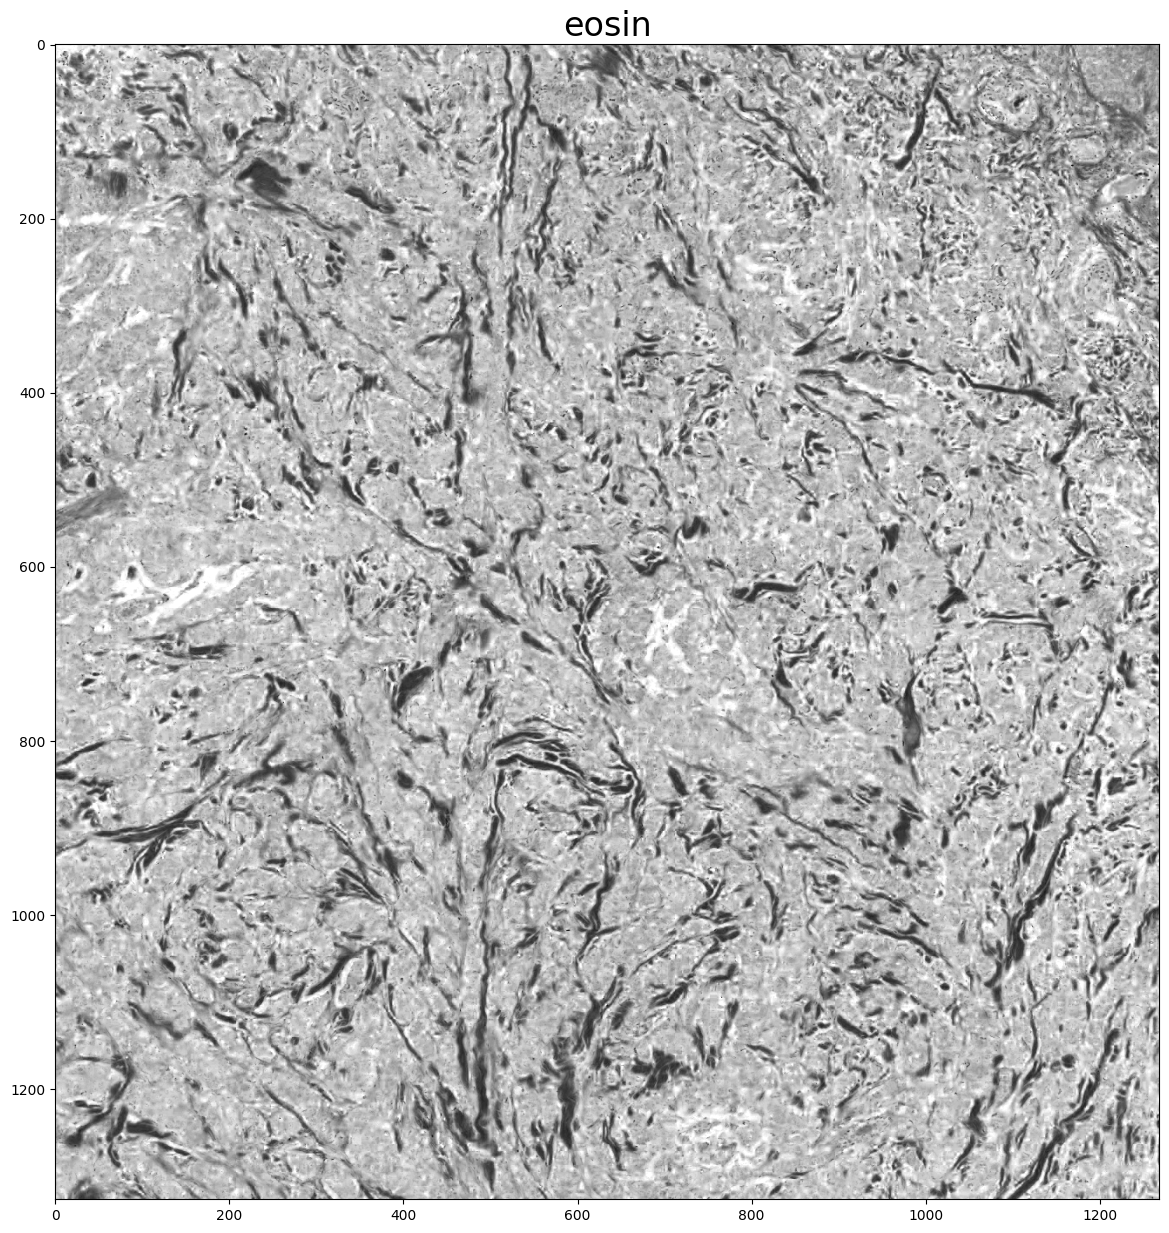

In [ ]:
from __future__ import print_function

import histomicstk as htk

import numpy as np

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24



target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
target_array = np.array(target)
I_0 = 240 # 240 is the default for brightfield images. Otherwise 255.



# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(target_array, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)



    
w_est = histomicstk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(target_array, I_0)

# Perform color deconvolution
deconv_result = histomicstk.preprocessing.color_deconvolution.color_deconvolution(target_array, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = histomicstk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)


In [8]:
import histomicstk.preprocessing.color_deconvolution as htk_deconv
import histomicstk.preprocessing.color_conversion as htk_color_conv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load input image
input_image_path = f"{INPUT_FOLDER}/AAGCCATAGTCGCGAC_row1_col1_100um.jpg"  # Replace with your input image path
input_image = np.array(Image.open(input_image_path).convert("RGB")) / 255.0  # Normalize to [0, 1]

# Define standard stain matrix for H&E
W_standard_he = np.array([
    [0.650, 0.704, 0.286],  # Hematoxylin
    [0.072, 0.990, 0.105],  # Eosin
    [0.0, 0.0, 0.0],        # Residual (ignored in normalization)
]).T

# Perform color deconvolution to extract stain concentrations
stain_concentrations = htk_deconv.color_deconvolution(input_image, W_standard_he).Stains

# Normalize stain concentrations (optional scaling for visibility)
#stain_concentrations = np.clip(stain_concentrations, 0, 1)

# Recompose the image using the stain concentrations and standard H&E matrix
normalized_image = htk_color_conv.concentrations_to_rgb(stain_concentrations, W_standard_he)

# Save and visualize the result
normalized_image = np.clip(normalized_image, 0, 1)  # Ensure valid range
normalized_image_pil = Image.fromarray((normalized_image * 255).astype('uint8'))
normalized_image_pil.save("normalized_image_standard.jpg")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.title("Normalized Image (Standard H&E)")
plt.imshow(normalized_image)
plt.show()


AttributeError: module 'histomicstk.preprocessing.color_conversion' has no attribute 'concentrations_to_rgb'

/tmp/ipykernel_1498353/3461316833.py:27: RuntimeWarning: invalid value encountered in cast
  reconstructed_image_pil = Image.fromarray((reconstructed_rgb * 255).astype('uint8'))


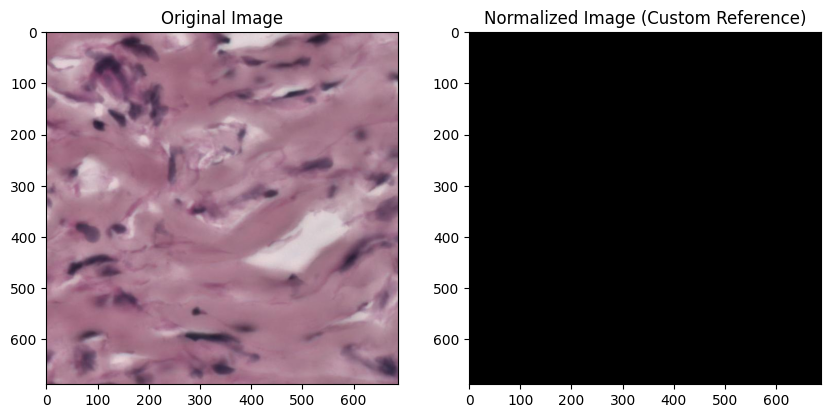

In [15]:
import histomicstk.preprocessing.color_deconvolution as htk_deconv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load reference image
reference_image_path = "reference_images/reference_full.jpeg"  # Replace with your reference image path
reference_image = np.array(Image.open(reference_image_path).convert("RGB"))# / 255.0  # Normalize to [0, 1]

# Compute the stain matrix (W) from the reference image using Macenko PCA
I_0 = 240  # Brightfield intensity (use 255 if your images are normalized)
W_ref = htk_deconv.rgb_separate_stains_macenko_pca(reference_image, I_0)

# Load input image
input_image_path = f"{INPUT_FOLDER}/AAGCCATAGTCGCGAC_row1_col1_100um.jpg"  # Replace with your input image path
input_image = np.array(Image.open(input_image_path).convert("RGB"))# / 255.0  # Normalize to [0, 1]

# Perform color deconvolution using the reference stain matrix
stain_deconvolved = htk_deconv.color_deconvolution(input_image, W_ref)
stain_concentrations = stain_deconvolved.Stains

# Recompose RGB image from stain concentrations
reconstructed_rgb = np.exp(-np.dot(stain_concentrations, W_ref.T)) * I_0

# Normalize to [0, 1] for visualization and save the result
reconstructed_rgb = np.clip(reconstructed_rgb / I_0, 0, 1)
reconstructed_image_pil = Image.fromarray((reconstructed_rgb * 255).astype('uint8'))
reconstructed_image_pil.save("normalized_image_reference.jpg")

# Visualize the original and normalized images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.title("Normalized Image (Custom Reference)")
plt.imshow(reconstructed_image_pil)
plt.show()


In [11]:
if use_default_target:
    # Setting up the paths for default target
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/target_is_default"
    print(output_folder)
    
    # TCGA-A2-A3XS-DX1_xmin21421_ymin37486_.png, Amgad et al, 2019)
    # for macenco (obtained using rgb_separate_stains_macenko_pca()
    # and reordered such that columns are the order:
    # Hamtoxylin, Eosin, Null
    W_target = np.array([
        [0.5807549,  0.08314027,  0.08213795],
        [0.71681094,  0.90081588,  0.41999816],
        [0.38588316,  0.42616716, -0.90380025],
    ])
    im_target = None
    
else:
    # Setting up the paths using a personalised image as target
    TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
    target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
    output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
    print(output_folder)
    
    # Compute target statistics from target image
    target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
    im_target = np.array(target)
    I_0 = 240 # 240 is the default for brightfield images. Otherwise 255.
    #W_target= rgb_separate_stains_macenko_pca(target_array, I_0)
    #print(W_target)
    W_target = None

# Let's create the output folder files
os.makedirs(output_folder, exist_ok=True)

# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise.txt"


# Parameters for stain unmixing routine
stain_unmixing_routine_params = {
    'stains': ['hematoxylin', 'eosin'],
    'stain_unmixing_method': 'macenko_pca',
}

# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise_macenko.txt"

with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles have failed normalization:\n")
    
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            # Load image
            img = Image.open(image_path).convert("RGB")
            tissue_rgb = np.array(img)

            # Perform Macenko normalization
            tissue_rgb_normalized = deconvolution_based_normalization(
                tissue_rgb,
                W_target=W_target,
                im_target = im_target,
                stain_unmixing_routine_params=stain_unmixing_routine_params
            )
            
            # Clipping values that go out of range [0, 1]
            #tissue_rgb_normalized = np.clip(tissue_rgb_normalized, 0, 1)
            
            # Convert to PIL and save
            img_normed_pil = Image.fromarray((tissue_rgb_normalized * 255).astype('uint8'))
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_normalized_macenko.jpg")
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}: {str(e)}\n")


./output/satac_C1/v3_allspots/tiles_100/histomicsTK_macenko_nomasking/target_is_reference_full


KeyboardInterrupt: 

## 1.4 - Macenko with masking

In [5]:
use_default_target = False   # True if you want to use the default values from function example, False for using the choosen target image 
normalisation_method = 'histomicsTK_macenko_masking'

In [6]:
# Setting up the paths using a personalised image as target
TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
print(output_folder)

# Compute target statistics from target image
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
im_target = np.array(target)
#I_0 = 240 # 240 is the default for brightfield images. Otherwise 255.
#W_target= rgb_separate_stains_macenko_pca(target_array, I_0)
#print(W_target)
#W_target = None

# Let's create the output folder files
os.makedirs(output_folder, exist_ok=True)

# Parameters for stain unmixing routine
stain_unmixing_routine_params = {
    'stains': ['hematoxylin', 'eosin'],
    'stain_unmixing_method': 'macenko_pca',
}

# File to log normalization failures
normalisation_fails_file = f"{output_folder}/0_failed_to_normalise_macenko_with_masking.txt"

with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles have failed normalization:\n")
    
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            # Load image
            img = Image.open(image_path).convert("RGB")
            tissue_rgb = np.array(img)

            # Mask extraction without resizing because it's not a WSI, it's quite a small image
            mask_out, _ = get_tissue_mask(tissue_rgb, #deconvolve_first=True,
                n_thresholding_steps=1, sigma=1.5, min_size=30)
            # mask_out = resize(mask_out == 0, output_shape=tissue_rgb.shape[:2],
            #     order=0, preserve_range=True) == 1
            
            # Perform Macenko normalization
            tissue_rgb_normalized = deconvolution_based_normalization(
                tissue_rgb,
                #W_target=W_target,
                im_target = im_target,
                stain_unmixing_routine_params=stain_unmixing_routine_params,
                mask_out = mask_out
            )
            
            # Clipping values that go out of range [0, 1]
            #tissue_rgb_normalized = np.clip(tissue_rgb_normalized, 0, 1)
            
            # Convert to PIL and save
            img_normed_pil = Image.fromarray((tissue_rgb_normalized * 255).astype('uint8'))
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_macenko_htk_normalised_withmasking.jpg")
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}: {str(e)}\n")


./output/satac_C1/v3_allspots/tiles_100/histomicsTK_macenko_masking/target_is_reference_full


/disk2/user/gabgam/miniconda3/envs/he_histomicstk_39/lib/python3.9/site-packages/histomicstk/saliency/tissue_detection.py:106: FutureWarning: Parameter `output` is deprecated since version 0.23 and will be removed in 0.25 (or later). To avoid this warning, please use the parameter `out` instead. For more details, see the documentation of `gaussian`.
  thumbnail = gaussian(
/disk2/user/gabgam/miniconda3/envs/he_histomicstk_39/lib/python3.9/site-packages/histomicstk/preprocessing/color_deconvolution/complement_stain_matrix.py:30: RuntimeWarning: invalid value encountered in divide
  return np.array([stain0, stain1, stain2 / np.linalg.norm(stain2)]).T


---
# Final - Saving the environment requirements

In [ ]:
# Save package versions to a .txt file
with open("requirements_for_histomicstk_env.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)